In [1]:
import gym
import numpy as np
import random
from timeit import default_timer as timer
from datetime import timedelta
import matplotlib.pylab as plt
import pandas as pd
import seaborn as sns

In [2]:
from gym.envs.toy_text.frozen_lake import generate_random_map, FrozenLakeEnv
np.random.seed(2)
sixteen = generate_random_map(16)
np.random.seed(44)
tvelve = generate_random_map(12)
MAPS = {
    "4x4": [
        "SFFF",
        "FHFH",
        "FFFH",
        "HFFG"
    ],
    "8x8": [
        "SFFFFFFF",
        "FFFFFFFF",
        "FFFHFFFF",
        "FFFFFHFF",
        "FFFHFFFF",
        "FHHFFFHF",
        "FHFFHFHF",
        "FFFHFFFG"
    ],
    "12x12": tvelve,
    "16x16": sixteen
}

In [3]:
def test_policy(env, policy, n_epoch=1000):
    rewards = []
    episode_counts = []
    for i in range(n_epoch):
        current_state = env.reset()
        ep = 0
        done = False
        episode_reward = 0
        while not done and ep < 1000:
            ep += 1
            act = int(policy[current_state])
            new_state, reward, done, _ = env.step(act)
            episode_reward += reward
            current_state = new_state
            
#         if ep>=1000:
#             print('over limit')
        rewards.append(episode_reward)
        episode_counts.append(ep)
    
    # all done
    mean_reward = sum(rewards)/len(rewards)
    mean_eps = sum(episode_counts)/len(episode_counts)
    return mean_reward, mean_eps, rewards, episode_counts 

In [4]:
def value_iteration(env, discount=0.9, epsilon=1e-12):
    
    start = timer()
    
    number_of_states = env.observation_space.n
    number_of_actions = env.action_space.n
    policy = np.zeros((1, number_of_states))
    value_list = np.zeros((1, number_of_states))
    old_value_list = value_list.copy()
    episode = 0
    max_change = 1
    sigma = discount
    while max_change > epsilon:
        episode += 1
        for s in range(number_of_states):
            assigned_value = -np.inf
            for a in range(number_of_actions):
                # get new state and its reward        
                total_cand_value = 0
                for prob, new_state, reward, done in env.P[s][a]:
                    # get new states value
                    value_new_state = old_value_list[0][new_state]
                    cand_value = 0
                    if done:
                        cand_value = reward 
                    else:
                        cand_value = reward + sigma*value_new_state
                    total_cand_value += cand_value*prob 
                        
                if total_cand_value > assigned_value:
                    assigned_value = total_cand_value
                    policy[0][s] = a
                    value_list[0][s] = assigned_value
        changes = np.abs(value_list - old_value_list)
        max_change = np.max(changes)
        old_value_list = value_list.copy()
        
    end = timer()
    time_spent = timedelta(seconds=end-start)
    print("Solved in: {} episodes and {} seconds".format(episode, time_spent))
    return policy[0], episode, time_spent

In [5]:
def policy_iteration(env, discount=0.9, epsilon=1e-3):
    
    start = timer()
    
    number_of_states = env.observation_space.n
    number_of_actions = env.action_space.n
    ## 1
    policy = np.random.randint(number_of_actions, size=(1,number_of_states))
#     policy = np.zeros((1,number_of_states))
    value_list = np.zeros((1, number_of_states))
    episode = 0
    sigma = discount
    
    ## 2
    policy_stable = False
    while not policy_stable:
        episode += 1
        eval_acc = True
        while eval_acc:
            eps = 0
            for s in range(number_of_states):
                # first row
                v = value_list[0][s]

                # get the new value 
                a = policy[0][s]
                total_val_new_state = 0
                for prob, new_state, reward, done in env.P[s][a]:
                    value_new_state = value_list[0][new_state]
                    # second row
                    cand_value = 0
                    if done:
                        cand_value = reward                     
                    else:
                        cand_value = reward + sigma*value_new_state
                    total_val_new_state += cand_value*prob 
                value_list[0][s] = total_val_new_state
                    
                # third row
                eps = max(eps, np.abs(v-value_list[0][s]))
            if eps < epsilon:
                eval_acc = False


        ## 3
        policy_stable = True
        for s in range(number_of_states):

            # assign 
            old_action = policy[0][s]
            # get the argmax a here
            max_value = -np.inf
            for a in range(number_of_actions):
                # get the new value 
                total_cand_value = 0
                for prob, new_state, reward, done in env.P[s][a]:
                    value_new_state = value_list[0][new_state]
                    cand_value = 0
                    if done:
                        cand_value = reward
                    else:
                        cand_value = reward + sigma*value_new_state
                    total_cand_value += prob*cand_value
                if total_cand_value > max_value:
                    max_value = total_cand_value
                    policy[0][s] = a

            # if old-action != policy[s]
            if old_action != policy[0][s]:
                policy_stable = False
    
    
    end = timer()
    time_spent = timedelta(seconds=end-start)
    print("Solved in: {} episodes and {} seconds".format(episode, time_spent))
    return policy[0], episode, time_spent
        

In [6]:
def train_and_test_pi_vi(env, discount=[0.9], epsilon=[1e-9], mute=False):
    
    vi_dict = {}
    
    for dis in discount:
        vi_dict[dis] = {}
        for eps in epsilon:
            vi_dict[dis][eps] = {}
            
            # run value iteration
            vi_policy, vi_solve_iter, vi_solve_time = value_iteration(env, dis, eps)
            vi_mrews, vi_meps, _, __ = test_policy(env, vi_policy)    
            vi_dict[dis][eps]["mean_reward"] = vi_mrews
            vi_dict[dis][eps]["mean_eps"] = vi_meps
            vi_dict[dis][eps]["iteration"] = vi_solve_iter
            vi_dict[dis][eps]["time_spent"] = vi_solve_time
            vi_dict[dis][eps]["policy"] = vi_policy
            if not mute:
                print("Value iteration for {} discount and {} eps is done".format(dis, eps))
                print("Iteration: {} time: {}".format(vi_solve_iter, vi_solve_time))
                print("Mean reward: {} - mean eps: {}".format(vi_mrews, vi_meps))
    # run policy iteration
    pi_dict = {}
    for dis in discount:
        pi_dict[dis] = {}
        for eps in epsilon:
            pi_dict[dis][eps] = {}

            pi_policy, pi_solve_iter, pi_solve_time = policy_iteration(env, dis, eps)
            pi_mrews, pi_meps, _, __ = test_policy(env, pi_policy)    
            pi_dict[dis][eps]["mean_reward"] = pi_mrews
            pi_dict[dis][eps]["mean_eps"] = pi_meps
            pi_dict[dis][eps]["iteration"] = pi_solve_iter
            pi_dict[dis][eps]["time_spent"] = pi_solve_time
            pi_dict[dis][eps]["policy"] = pi_policy
            if not mute:
                print("Policy iteration for {} discount is done".format(dis))
                print("Iteration: {} time: {}".format(pi_solve_iter, pi_solve_time))
                print("Mean reward: {} - mean eps: {}".format(pi_mrews, pi_meps))

    
    return vi_dict, pi_dict

In [67]:
def map_discretize(the_map):
    size = len(the_map)
    dis_map = np.zeros((size,size))
    for i, row in enumerate(the_map):
        for j, loc in enumerate(row):
            if loc == "S":
                dis_map[i, j] = 0
            elif loc == "F":
                dis_map[i, j] = 0
            elif loc == "H":
                dis_map[i, j] = -1
            elif loc == "G":
                dis_map[i, j] = 1
    return dis_map


def policy_numpy(policy):
    size = int(np.sqrt(len(policy)))
    pol = np.asarray(policy)
    pol = pol.reshape((size, size))
    return pol


def see_policy(map_size, policy):
    map_name = str(map_size)+"x"+str(map_size)
    data = map_discretize(MAPS[map_name])
    np_pol = policy_numpy(policy)
    plt.imshow(data, interpolation="nearest")

    for i in range(np_pol[0].size):
        for j in range(np_pol[0].size):
            arrow = '\u2190'
            if np_pol[i, j] == 1:
                arrow = '\u2193'
            elif np_pol[i, j] == 2:
                arrow = '\u2192'
            elif np_pol[i, j] == 3:
                arrow = '\u2191'
            text = plt.text(j, i, arrow,
                           ha="center", va="center", color="w",size=10)
    plt.show()


In [90]:
def plot_the_dict(dictionary, value="Score", size=4, variable="Discount Rate", log=False):

    plt.figure(figsize=(12, 8))
    title = "Average and Max {} on {}x{} Frozen Lake".format(value, size, size)
    the_val = value
    value = "Average {}".format(the_val)
    val_type = "Type of {}".format(the_val)
    the_df = pd.DataFrame(columns=[variable, value, val_type])
    for k, v in dictionary.items():
        for val in v:
            if not log:
                dic = {variable: k, value: float(val), val_type: "Average with std"}
            else:
                dic = {variable: np.log10(k), value: float(val), val_type: "Average with std"}                
            the_df = the_df.append(dic, ignore_index=True)
        if not log:
            dic = {variable: k, value: float(max(v)), val_type: "Max"}
        else:
            dic = {variable: np.log10(k), value: float(max(v)), val_type: "Max"}
        the_df = the_df.append(dic, ignore_index=True)
            
    sns.set_context("paper", rc={"font.size":20,"axes.titlesize":20,"axes.labelsize":15,"lines.linewidth": 5}) 
    sns.set_context("poster")
    sns.lineplot(x=variable, y=value, hue=val_type, style=val_type, markers=True, data=the_df).set(title=title)

In [9]:
def convert_dict_to_dict(the_dict):
    
    # return for discount
    discount_rewards = {}
    discount_iterations = {}
    discount_times = {}


    for disc in the_dict:
        discount_rewards[disc] = []    
        discount_iterations[disc] = []    
        discount_times[disc] = []

        for eps in the_dict[disc]:
            discount_rewards[disc].append(the_dict[disc][eps]['mean_reward'])
            discount_iterations[disc].append(the_dict[disc][eps]['iteration'])        
            discount_times[disc].append(the_dict[disc][eps]['time_spent'].total_seconds())  

            
    epsilon_rewards = {}
    epsilon_iterations = {}
    epsilon_times = {}
    for eps in the_dict[0.5]:
        epsilon_rewards[eps] = []    
        epsilon_iterations[eps] = []    
        epsilon_times[eps] = []
    
        for disc in vi_dict:
            epsilon_rewards[eps].append(the_dict[disc][eps]['mean_reward'])
            epsilon_iterations[eps].append(the_dict[disc][eps]['iteration'])        
            epsilon_times[eps].append(the_dict[disc][eps]['time_spent'].total_seconds()) 
            
    return discount_rewards, discount_iterations, discount_times, epsilon_rewards, epsilon_iterations, epsilon_times

## 4x4

In [10]:
env = gym.make("FrozenLake-v0")
vi_dict, pi_dict = train_and_test_pi_vi(env, discount=[0.5, 0.75, 0.9, 0.95, 0.99, 0.9999], 
                                        epsilon=[1e-3, 1e-6, 1e-9, 1e-12, 1e-15], mute=True)

Solved in: 7 episodes and 0:00:00.003683 seconds
Solved in: 16 episodes and 0:00:00.004914 seconds
Solved in: 25 episodes and 0:00:00.007583 seconds
Solved in: 34 episodes and 0:00:00.010818 seconds
Solved in: 44 episodes and 0:00:00.013051 seconds
Solved in: 12 episodes and 0:00:00.003679 seconds
Solved in: 33 episodes and 0:00:00.009947 seconds
Solved in: 53 episodes and 0:00:00.015336 seconds
Solved in: 73 episodes and 0:00:00.021944 seconds
Solved in: 94 episodes and 0:00:00.028776 seconds
Solved in: 27 episodes and 0:00:00.007857 seconds
Solved in: 78 episodes and 0:00:00.023336 seconds
Solved in: 129 episodes and 0:00:00.038666 seconds
Solved in: 179 episodes and 0:00:00.053531 seconds
Solved in: 230 episodes and 0:00:00.068880 seconds
Solved in: 44 episodes and 0:00:00.013086 seconds
Solved in: 128 episodes and 0:00:00.037749 seconds
Solved in: 213 episodes and 0:00:00.060868 seconds
Solved in: 297 episodes and 0:00:00.085748 seconds
Solved in: 381 episodes and 0:00:00.113074 se

In [11]:
vi_dict[0.99]

{0.001: {'mean_reward': 0.715,
  'mean_eps': 45.223,
  'iteration': 105,
  'time_spent': datetime.timedelta(microseconds=33581),
  'policy': array([0., 3., 3., 3., 0., 0., 0., 0., 3., 1., 0., 0., 0., 2., 1., 0.])},
 1e-06: {'mean_reward': 0.739,
  'mean_eps': 44.907,
  'iteration': 305,
  'time_spent': datetime.timedelta(microseconds=86889),
  'policy': array([0., 3., 3., 3., 0., 0., 0., 0., 3., 1., 0., 0., 0., 2., 1., 0.])},
 1e-09: {'mean_reward': 0.748,
  'mean_eps': 45.636,
  'iteration': 504,
  'time_spent': datetime.timedelta(microseconds=143858),
  'policy': array([0., 3., 3., 3., 0., 0., 0., 0., 3., 1., 0., 0., 0., 2., 1., 0.])},
 1e-12: {'mean_reward': 0.755,
  'mean_eps': 44.358,
  'iteration': 704,
  'time_spent': datetime.timedelta(microseconds=200950),
  'policy': array([0., 3., 3., 3., 0., 0., 0., 0., 3., 1., 0., 0., 0., 2., 1., 0.])},
 1e-15: {'mean_reward': 0.741,
  'mean_eps': 45.663,
  'iteration': 903,
  'time_spent': datetime.timedelta(microseconds=258007),
  'polic

In [12]:
pi_dict[0.9999]

{0.001: {'mean_reward': 0.772,
  'mean_eps': 44.704,
  'iteration': 7,
  'time_spent': datetime.timedelta(microseconds=36267),
  'policy': array([0, 3, 3, 3, 0, 0, 0, 0, 3, 1, 0, 0, 0, 2, 1, 0])},
 1e-06: {'mean_reward': 0.717,
  'mean_eps': 47.158,
  'iteration': 3,
  'time_spent': datetime.timedelta(microseconds=92105),
  'policy': array([0, 3, 3, 3, 0, 0, 0, 0, 3, 1, 0, 0, 0, 2, 1, 0])},
 1e-09: {'mean_reward': 0.737,
  'mean_eps': 43.619,
  'iteration': 4,
  'time_spent': datetime.timedelta(microseconds=191432),
  'policy': array([0, 3, 3, 3, 0, 0, 0, 0, 3, 1, 0, 0, 0, 2, 1, 0])},
 1e-12: {'mean_reward': 0.745,
  'mean_eps': 44.293,
  'iteration': 4,
  'time_spent': datetime.timedelta(microseconds=278253),
  'policy': array([0, 3, 3, 3, 0, 0, 0, 0, 3, 1, 0, 0, 0, 2, 1, 0])},
 1e-15: {'mean_reward': 0.785,
  'mean_eps': 44.001,
  'iteration': 4,
  'time_spent': datetime.timedelta(microseconds=279985),
  'policy': array([0, 3, 3, 3, 0, 0, 0, 0, 3, 1, 0, 0, 0, 2, 1, 0])}}

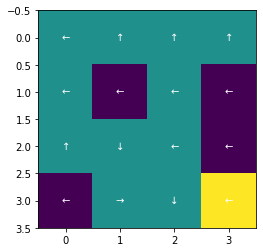

In [13]:
pol = vi_dict[0.99][1e-12]['policy']
vi4 = convert_dict_to_dict(vi_dict)
see_policy(4, pol)

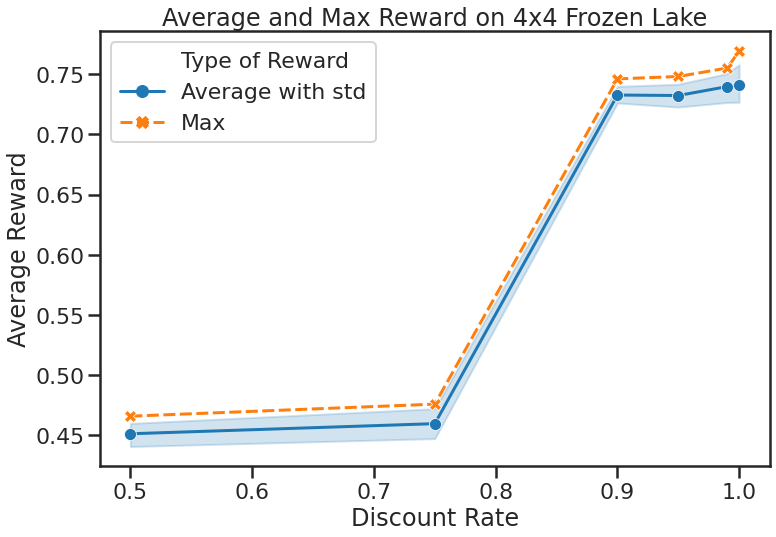

In [91]:
plot_the_dict(vi4[0], value="Reward", size=4)

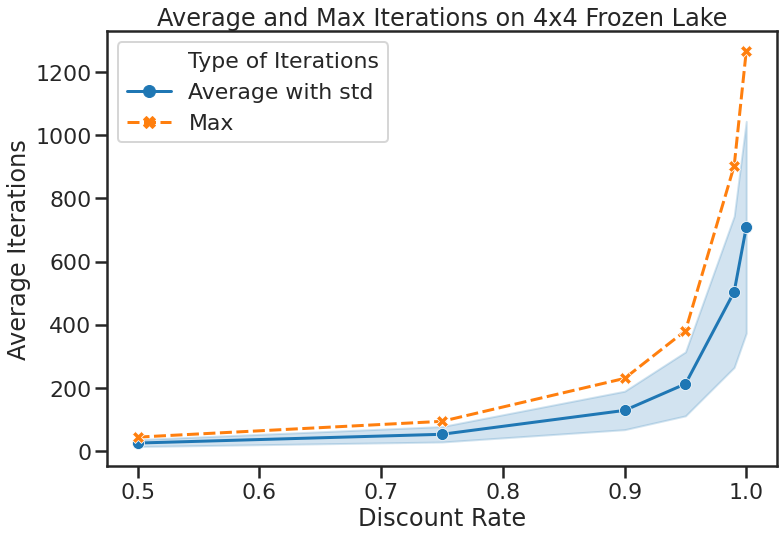

In [92]:
plot_the_dict(vi4[1], value="Iterations", size=4)

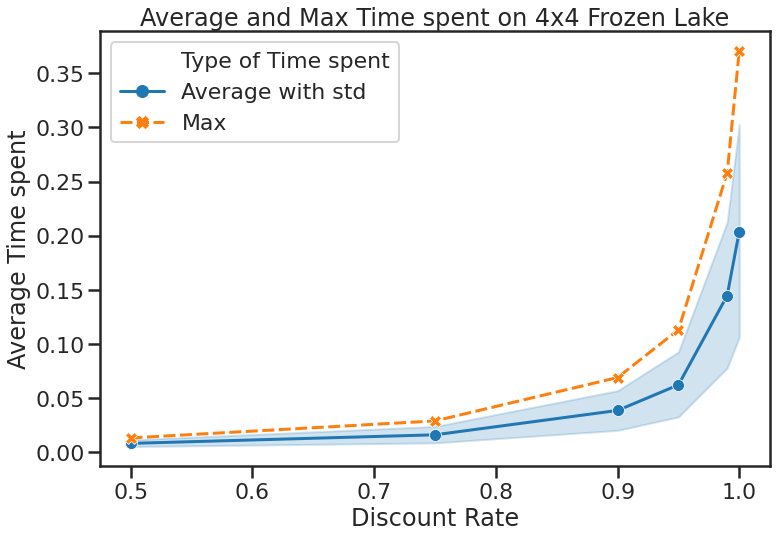

In [93]:
plot_the_dict(vi4[2], value="Time spent", size=4)

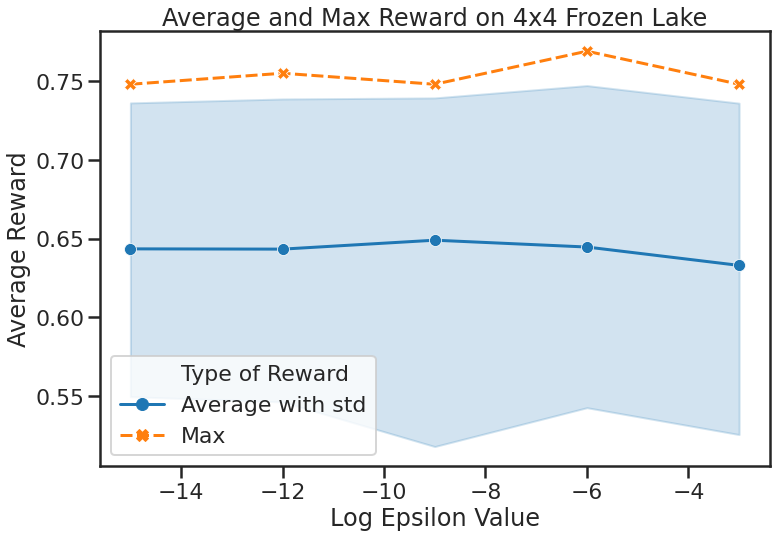

In [94]:
plot_the_dict(vi4[3], value="Reward", size=4, variable="Log Epsilon Value", log=True)

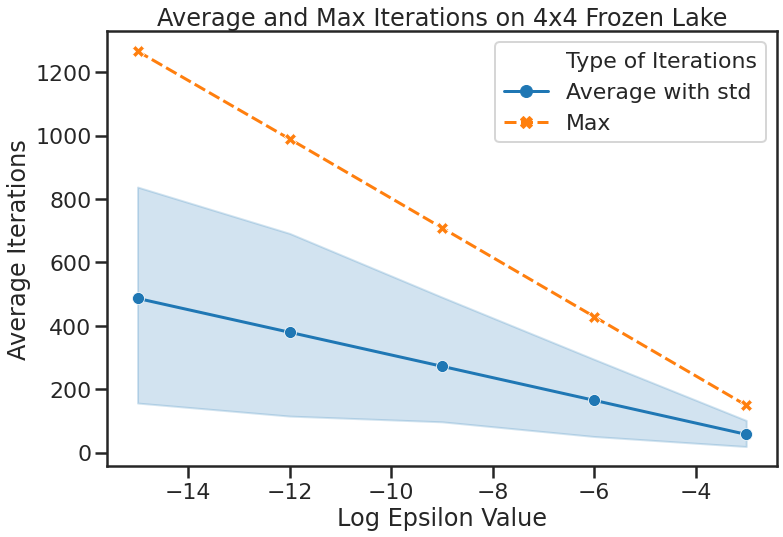

In [95]:
plot_the_dict(vi4[4], value="Iterations", size=4, variable="Log Epsilon Value", log=True)

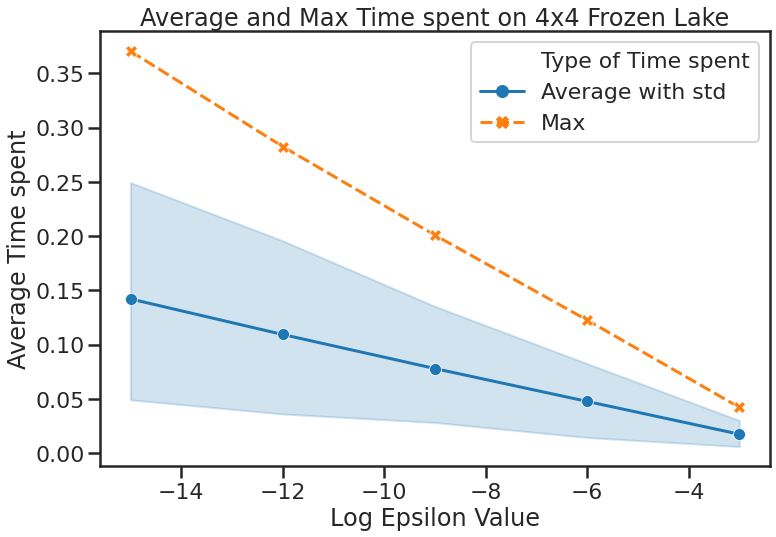

In [96]:
plot_the_dict(vi4[5], value="Time spent", size=4, variable="Log Epsilon Value", log=True)

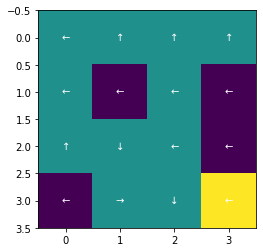

In [20]:
pol = pi_dict[0.99][1e-12]['policy']
pi4 = convert_dict_to_dict(pi_dict)
see_policy(4, pol)

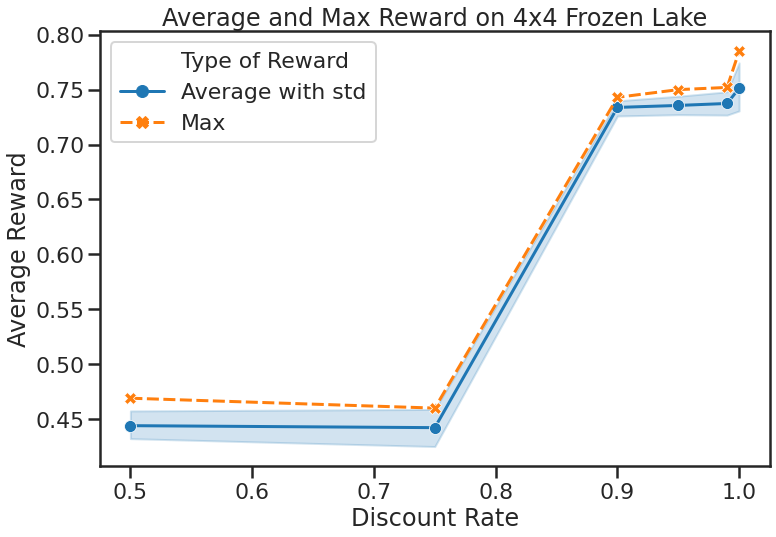

In [97]:
plot_the_dict(pi4[0], value="Reward", size=4)

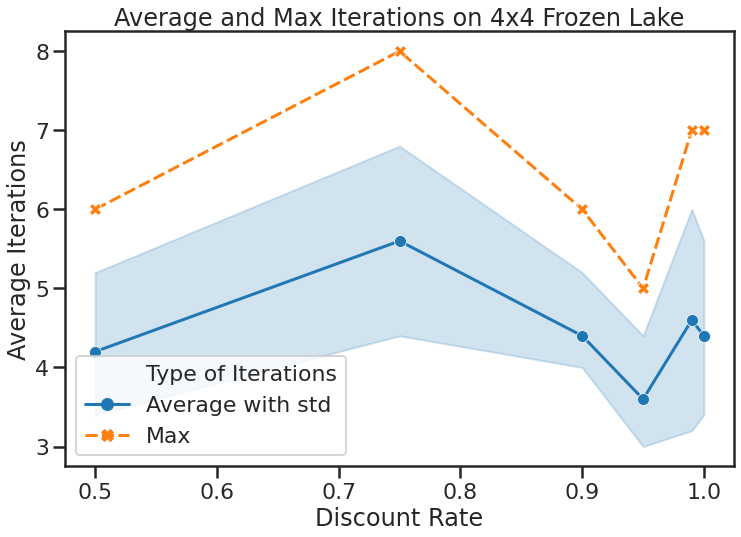

In [98]:
plot_the_dict(pi4[1], value="Iterations", size=4)

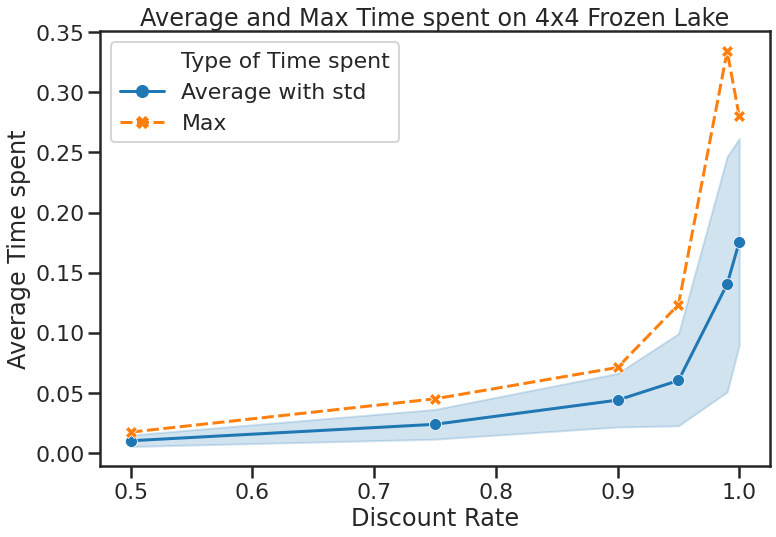

In [99]:
plot_the_dict(pi4[2], value="Time spent", size=4)

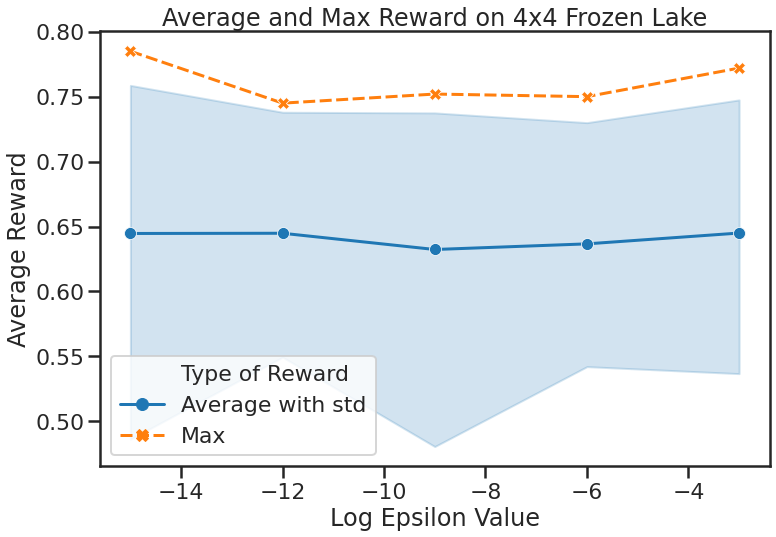

In [100]:
plot_the_dict(pi4[3], value="Reward", size=4, variable="Log Epsilon Value", log=True)

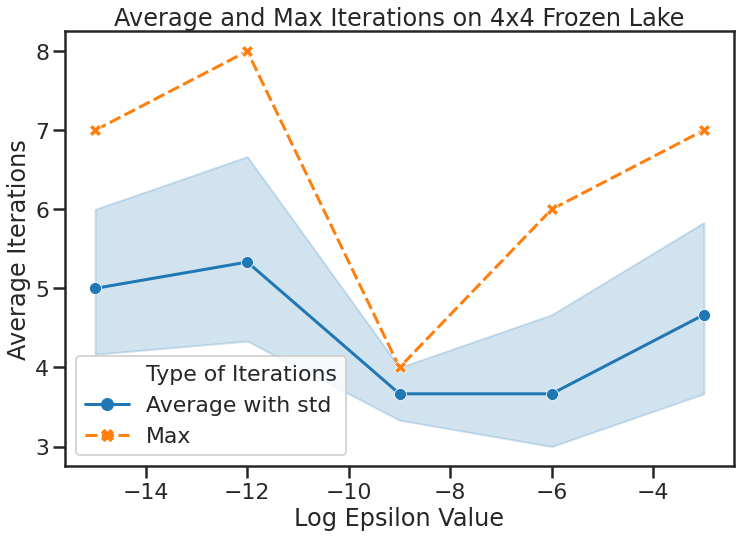

In [101]:
plot_the_dict(pi4[4], value="Iterations", size=4, variable="Log Epsilon Value", log=True)

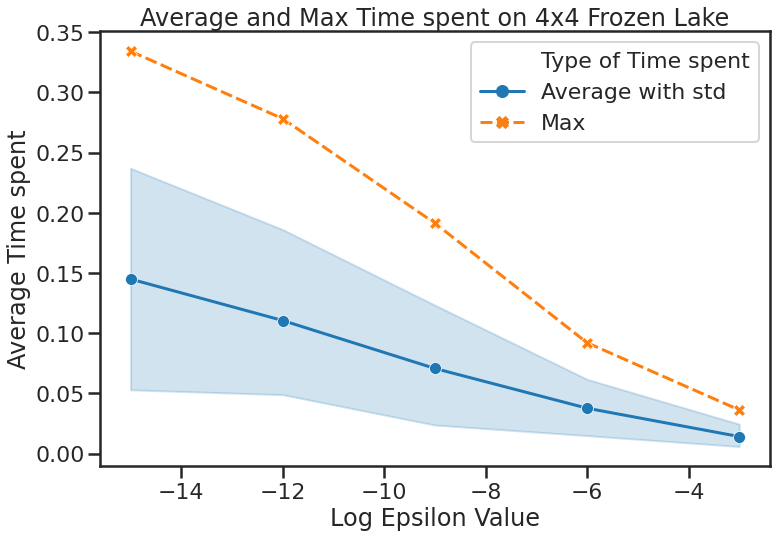

In [102]:
plot_the_dict(pi4[5], value="Time spent", size=4, variable="Log Epsilon Value", log=True)

## 16 x 16

In [27]:
env = FrozenLakeEnv(desc=MAPS["16x16"])
vi_dict16, pi_dict16 = train_and_test_pi_vi(env, discount=[0.5, 0.75, 0.9, 0.95, 0.99, 0.9999], 
                                          epsilon=[1e-3, 1e-6, 1e-9, 1e-12, 1e-15], mute=True)

Solved in: 7 episodes and 0:00:00.028535 seconds
Solved in: 15 episodes and 0:00:00.044673 seconds
Solved in: 24 episodes and 0:00:00.071084 seconds
Solved in: 34 episodes and 0:00:00.102982 seconds
Solved in: 43 episodes and 0:00:00.129608 seconds
Solved in: 12 episodes and 0:00:00.035228 seconds
Solved in: 31 episodes and 0:00:00.094085 seconds
Solved in: 54 episodes and 0:00:00.166701 seconds
Solved in: 77 episodes and 0:00:00.238893 seconds
Solved in: 100 episodes and 0:00:00.310295 seconds
Solved in: 20 episodes and 0:00:00.058525 seconds
Solved in: 77 episodes and 0:00:00.249708 seconds
Solved in: 138 episodes and 0:00:00.425451 seconds
Solved in: 199 episodes and 0:00:00.620890 seconds
Solved in: 260 episodes and 0:00:00.809658 seconds
Solved in: 31 episodes and 0:00:00.095120 seconds
Solved in: 147 episodes and 0:00:00.474420 seconds
Solved in: 268 episodes and 0:00:00.845180 seconds
Solved in: 384 episodes and 0:00:01.214242 seconds
Solved in: 499 episodes and 0:00:01.601058 s

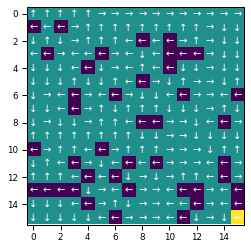

In [69]:
pol = vi_dict16[0.9999][1e-15]['policy']
vi16 = convert_dict_to_dict(vi_dict16)
see_policy(16, pol)

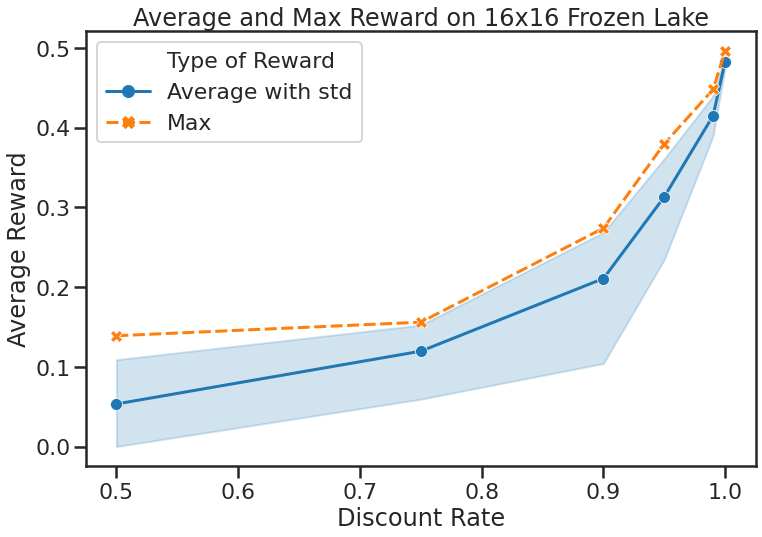

In [103]:
plot_the_dict(vi16[0], value="Reward", size=16)

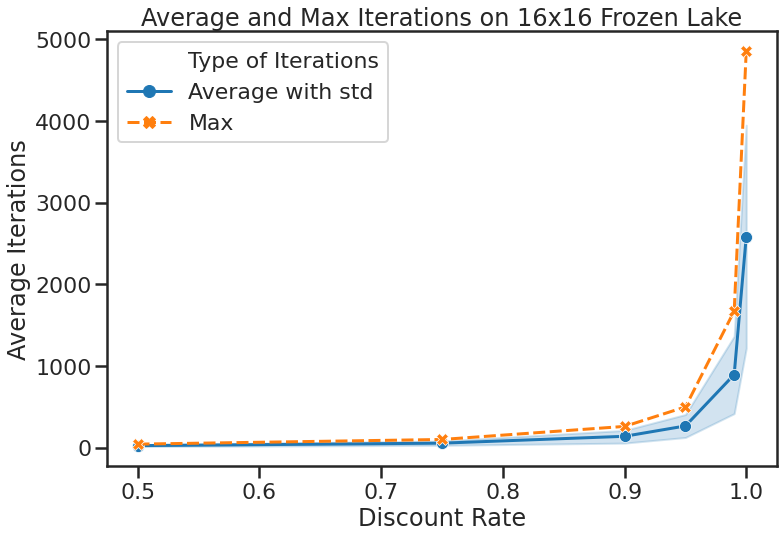

In [105]:
plot_the_dict(vi16[1], value="Iterations", size=16)

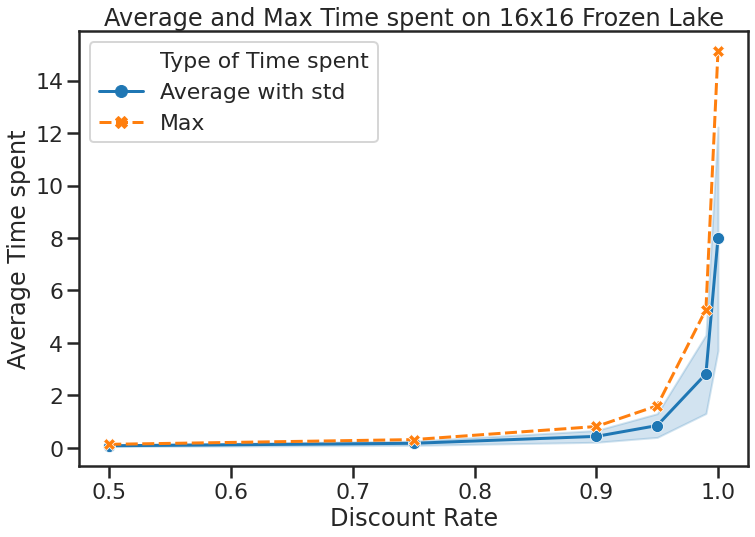

In [106]:
plot_the_dict(vi16[2], value="Time spent", size=16)

In [107]:
pi16 = convert_dict_to_dict(pi_dict16)

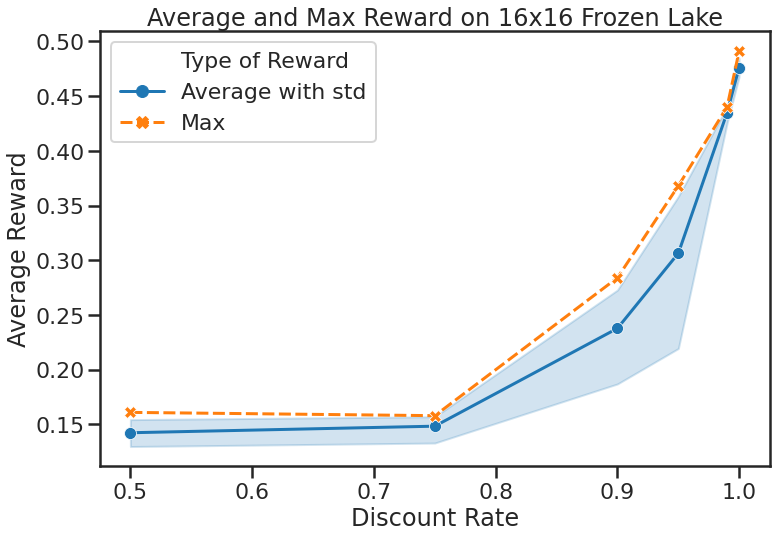

In [108]:
plot_the_dict(pi16[0], value="Reward", size=16)

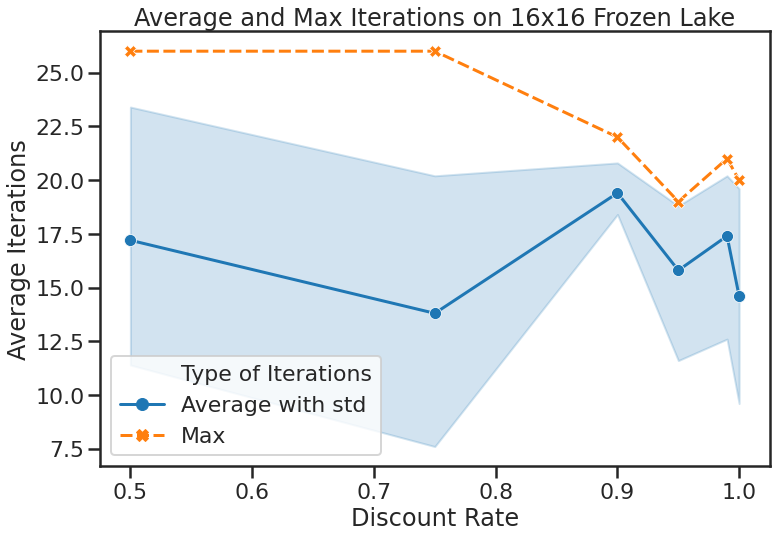

In [109]:
plot_the_dict(pi16[1], value="Iterations", size=16)

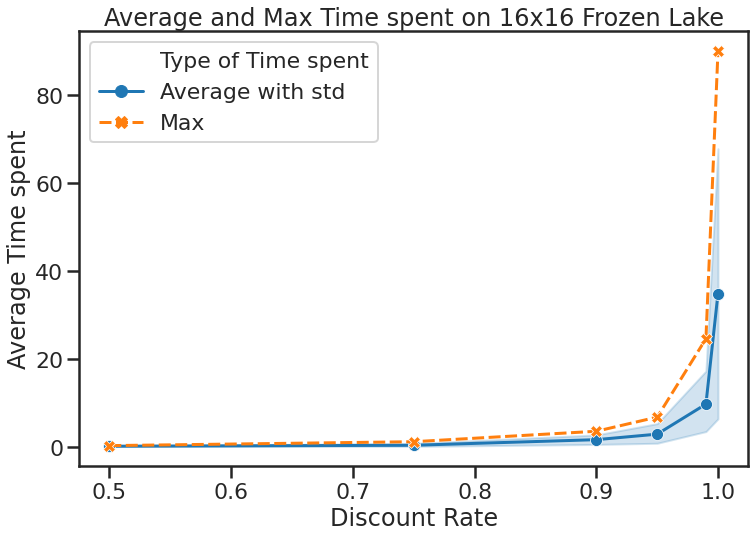

In [110]:
plot_the_dict(pi16[2], value="Time spent", size=16)

In [36]:
import dill
dill.dump_session('vi_pi_all.db')

ModuleNotFoundError: No module named 'dill'

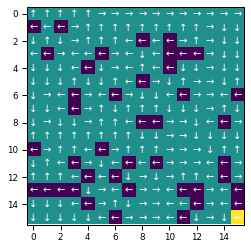

In [68]:
pol = pi_dict16[0.9999][1e-15]['policy']

see_policy(16, pol)

In [38]:
env

In [40]:
env.P[0]

{0: [(0.3333333333333333, 0, 0.0, False),
  (0.3333333333333333, 0, 0.0, False),
  (0.3333333333333333, 16, 0.0, True)],
 1: [(0.3333333333333333, 0, 0.0, False),
  (0.3333333333333333, 16, 0.0, True),
  (0.3333333333333333, 1, 0.0, False)],
 2: [(0.3333333333333333, 16, 0.0, True),
  (0.3333333333333333, 1, 0.0, False),
  (0.3333333333333333, 0, 0.0, False)],
 3: [(0.3333333333333333, 1, 0.0, False),
  (0.3333333333333333, 0, 0.0, False),
  (0.3333333333333333, 0, 0.0, False)]}

In [156]:
import matplotlib.pyplot as plt
import numpy as np

def plot_vi_pi(vi4,pi4,vi16,pi16,index ):
    # index 0 for reward vs discount 
    # index 1 for iterations vs discount 
    # index 2 for time spent vs discount 
    # index 3 for reward vs epsilon 
    # index 4 for iterations vs epsilon 
    # index 5 for time spent vs epsilon 
    
    x_labels=['Discount','Discount','Discount','Log Epsilon','Log Epsilon','Log Epsilon']
    y_labels=['Reward','Iterations','Time Spent','Reward','Iterations','Time Spent']
    
    x_label=x_labels[index]
    y_label=y_labels[index]
    fig=plt.figure(figsize = (8,10)) 
    ax = fig.add_subplot(2, 1, 1)

    
    if index>2:
        ax.set_xscale('log')
    keys=[]
    values=[]
    errors=[]
    maximums=[]
    for k,v in vi4[index].items():
        keys.append(k)
        values.append(np.average(v))
        errors.append(np.std(v))
        maximums.append(np.max(v))
    
    
    plt.errorbar(keys, values, errors, linestyle='--',linewidth=4, marker='^',label="VI frozenlake 4x4")
    
    keys=[]
    values=[]
    errors=[]
    maximums=[]
    for k,v in pi4[index].items():
        keys.append(k)
        values.append(np.average(v))
        errors.append(np.std(v))
        maximums.append(np.max(v))    
    
    plt.errorbar(keys, values, errors, linestyle='--',linewidth=4, marker='^',label="PI frozenlake 4x4")

    
    keys=[]
    values=[]
    errors=[]
    maximums=[]
    for k,v in vi16[index].items():
        keys.append(k)
        values.append(np.average(v))
        errors.append(np.std(v))
        maximums.append(np.max(v))    
    
    plt.errorbar(keys, values, errors, linestyle='--',linewidth=4, marker='^',label="VI frozenlake 16x16")
       
    keys=[]
    values=[]
    errors=[]
    maximums=[]
    for k,v in pi16[index].items():
        keys.append(k)
        values.append(np.average(v))
        errors.append(np.std(v))
        maximums.append(np.max(v))    
    
    plt.errorbar(keys, values, errors, linestyle='--',linewidth=4, marker='^',label="PI frozenlake 16x16")
       
        
    #plt.legend(loc='upper left')
    
    box = ax.get_position()
    ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])

    # Put a legend to the right of the current axis
    ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))

   
    
    title = "Average {} V.S. {} ".format(y_label,x_label)
    plt.title(title)
    plt.xlabel(x_label)
    plt.ylabel(y_label)

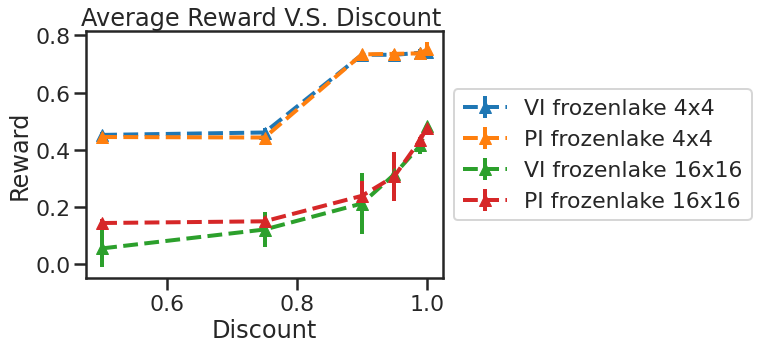

In [157]:
plot_vi_pi(vi4,pi4,vi16,pi16,0)

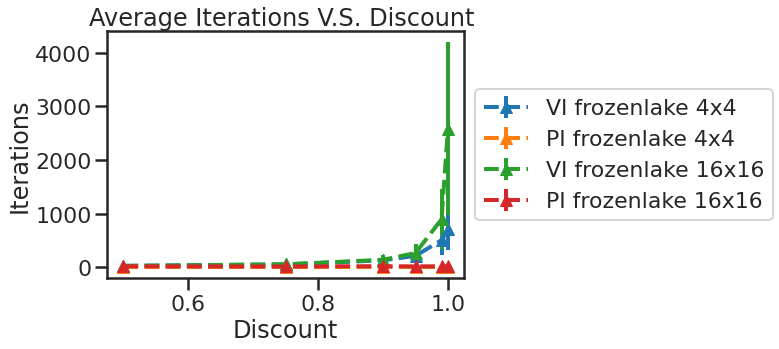

In [158]:
plot_vi_pi(vi4,pi4,vi16,pi16,1)

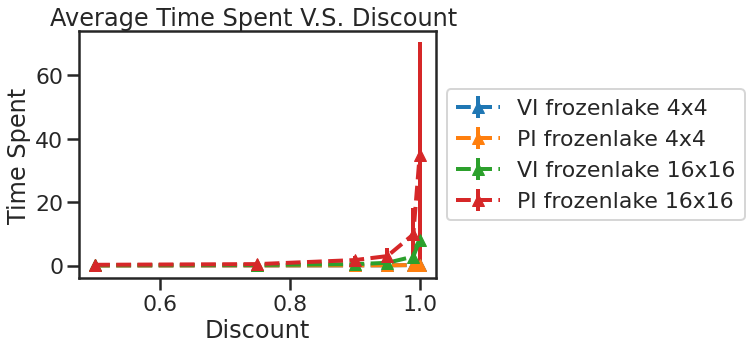

In [159]:
plot_vi_pi(vi4,pi4,vi16,pi16,2)

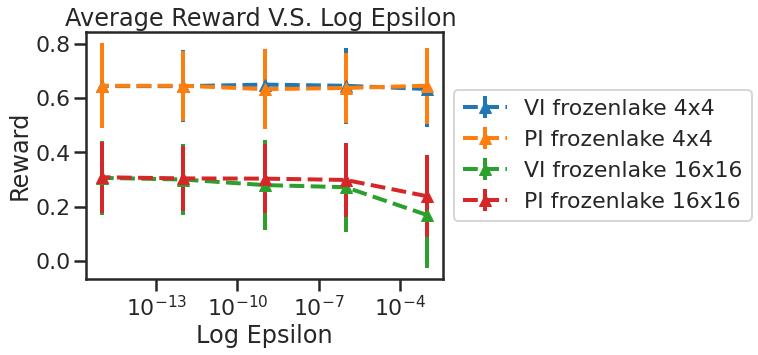

In [160]:
plot_vi_pi(vi4,pi4,vi16,pi16,3)

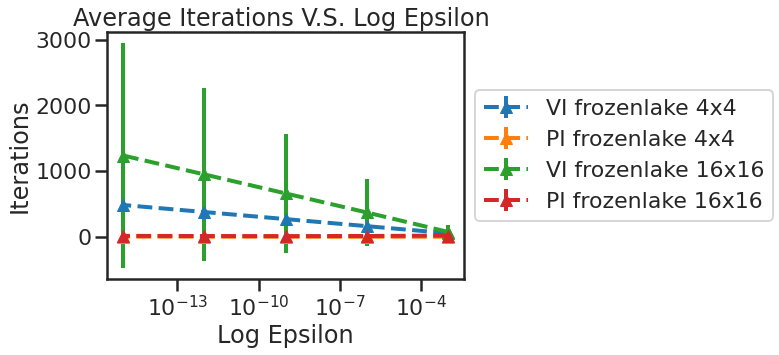

In [161]:
plot_vi_pi(vi4,pi4,vi16,pi16,4)

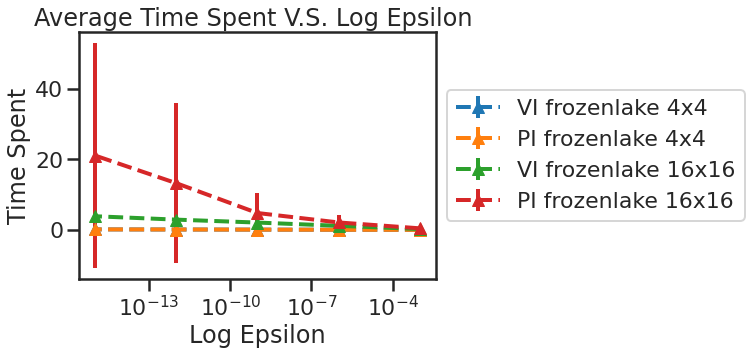

In [162]:
plot_vi_pi(vi4,pi4,vi16,pi16,5)